
# Assignment: Sentiment Analysis on Amazon Reviews


## Cell 1 — Imports (Colab-safe installs)

In [15]:

!pip -q install wordcloud

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from wordcloud import WordCloud


In [16]:
df = pd.read_csv("amazonreviews.tsv", sep="\t")
print("Shape:", df.shape)
df.head()


Shape: (10000, 2)


,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [17]:
print("Columns:", df.columns.tolist())
print("\nMissing values:\n", df.isna().sum())

dup_count = df.duplicated().sum()
print("\nDuplicate rows:", dup_count)

print("\nLabel distribution:")
print(df["label"].value_counts())


Columns: ['label', 'review']

Missing values:
 label     0
review    0
dtype: int64

Duplicate rows: 0

Label distribution:
label
neg    5097
pos    4903
Name: count, dtype: int64


In [18]:
df_clean = df.copy()

df_clean = df_clean.dropna(subset=["review"])
df_clean["review"] = df_clean["review"].astype(str).str.strip()
df_clean = df_clean[df_clean["review"] != ""]

df_clean = df_clean.drop_duplicates()

print("After cleaning shape:", df_clean.shape)
print(df_clean["label"].value_counts())


After cleaning shape: (10000, 2)
label
neg    5097
pos    4903
Name: count, dtype: int64


In [19]:
def basic_clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)           # remove urls
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()              # normalize spaces
    return text

df_clean["review_clean"] = df_clean["review"].apply(basic_clean_text)

df_clean[["label", "review", "review_clean"]].head()


,label,review,review_clean
0,pos,Stuning even for the non-gamer: This sound tra...,stuning even for the nongamer this sound track...
1,pos,The best soundtrack ever to anything.: I'm rea...,the best soundtrack ever to anything im readin...
2,pos,Amazing!: This soundtrack is my favorite music...,amazing this soundtrack is my favorite music o...
3,pos,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack i truly like this soundtr...
4,pos,"Remember, Pull Your Jaw Off The Floor After He...",remember pull your jaw off the floor after hea...


# 1) Exploratory Analysis (EDA)

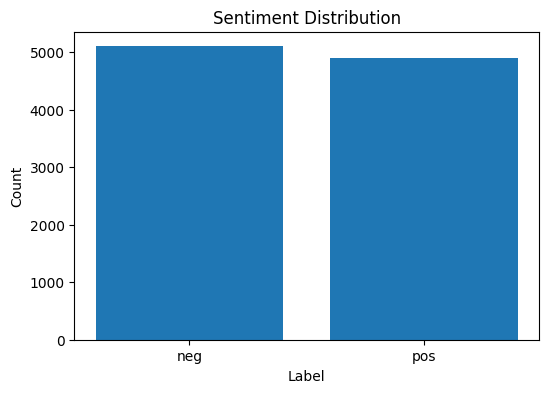

In [20]:
counts = df_clean["label"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values)
plt.title("Sentiment Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


In [21]:
from collections import Counter

def top_words(texts, n=20):
    words = " ".join(texts).split()
    return Counter(words).most_common(n)

pos_texts = df_clean.loc[df_clean["label"]=="pos", "review_clean"]
neg_texts = df_clean.loc[df_clean["label"]=="neg", "review_clean"]

print("Top Positive words:", top_words(pos_texts, 20))
print("\nTop Negative words:", top_words(neg_texts, 20))


Top Positive words: [('the', 19064), ('and', 11183), ('a', 10411), ('i', 8865), ('to', 8861), ('of', 8578), ('is', 7319), ('it', 7262), ('this', 6910), ('in', 5044), ('for', 4112), ('that', 3866), ('book', 3313), ('you', 3255), ('was', 3006), ('with', 2746), ('my', 2521), ('but', 2517), ('on', 2517), ('as', 2309)]

Top Negative words: [('the', 21640), ('i', 11188), ('to', 10381), ('and', 10103), ('a', 10025), ('it', 8797), ('of', 8280), ('this', 8278), ('is', 7261), ('in', 4773), ('not', 4398), ('was', 4376), ('that', 4274), ('for', 4192), ('but', 3271), ('book', 3183), ('you', 3091), ('on', 2996), ('with', 2874), ('have', 2717)]


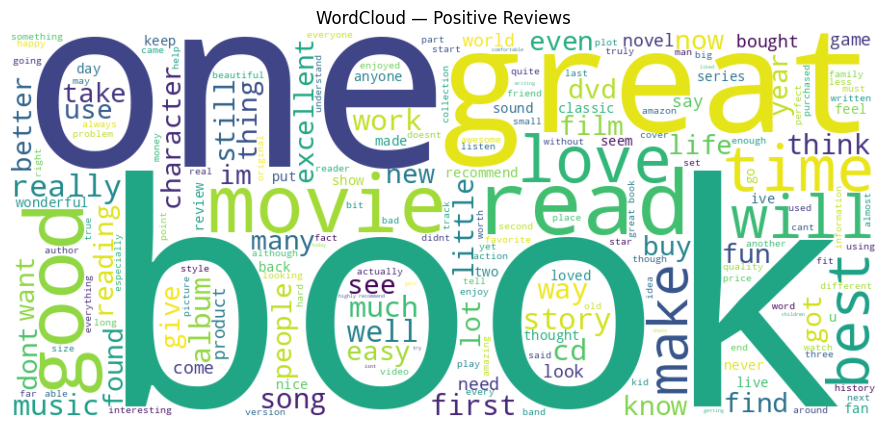

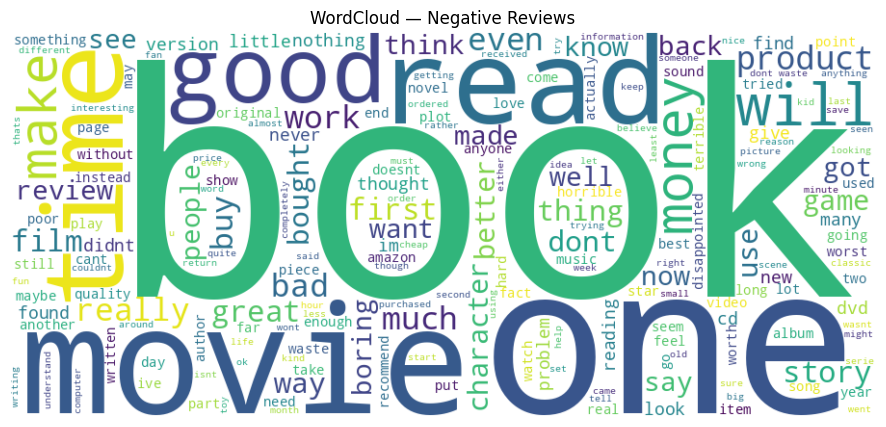

In [22]:
def plot_wordcloud(text_series, title):
    text = " ".join(text_series)
    wc = WordCloud(width=900, height=400, background_color="white").generate(text)
    plt.figure(figsize=(12,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wordcloud(pos_texts, "WordCloud — Positive Reviews")
plot_wordcloud(neg_texts, "WordCloud — Negative Reviews")


# 2) Model Development

In [23]:
X = df_clean["review_clean"]
y = df_clean["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train), "Test size:", len(X_test))
print("Train distribution:\n", y_train.value_counts(normalize=True))


Train size: 8000 Test size: 2000
Train distribution:
 label
neg    0.50975
pos    0.49025
Name: proportion, dtype: float64


In [24]:
tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=30000,
    ngram_range=(1,2)   # unigrams + bigrams helps sentiment a lot
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF Train shape:", X_train_tfidf.shape)


TF-IDF Train shape: (8000, 30000)


In [25]:
logreg = LogisticRegression(max_iter=300)
logreg.fit(X_train_tfidf, y_train)

y_pred_lr = logreg.predict(X_test_tfidf)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-score :", f1_score(y_test, y_pred_lr, pos_label="pos"))
print("\nReport:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Logistic Regression
Accuracy: 0.8555
F1-score : 0.8518708354689902

Report:
               precision    recall  f1-score   support

         neg       0.85      0.86      0.86      1019
         pos       0.86      0.85      0.85       981

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000

Confusion Matrix:
 [[880 139]
 [150 831]]


In [26]:
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

y_pred_svm = svm.predict(X_test_tfidf)

print("Linear SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1-score :", f1_score(y_test, y_pred_svm, pos_label="pos"))
print("\nReport:\n", classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))


Linear SVM
Accuracy: 0.8525
F1-score : 0.8504815002534212

Report:
               precision    recall  f1-score   support

         neg       0.86      0.85      0.85      1019
         pos       0.85      0.86      0.85       981

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

Confusion Matrix:
 [[866 153]
 [142 839]]


# 3) Validation (Cross-Validation)

In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression CV
lr_cv_scores = cross_val_score(logreg, X_train_tfidf, y_train, cv=cv, scoring="f1_macro")
svm_cv_scores = cross_val_score(svm, X_train_tfidf, y_train, cv=cv, scoring="f1_macro")

print("LogReg CV F1-macro mean:", lr_cv_scores.mean(), "std:", lr_cv_scores.std())
print("SVM   CV F1-macro mean:", svm_cv_scores.mean(), "std:", svm_cv_scores.std())


LogReg CV F1-macro mean: 0.8558249139393814 std: 0.010108671068372148
SVM   CV F1-macro mean: 0.8580820226230363 std: 0.008523307268166302
